### Import Library

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
import scipy.stats as scs
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

### Data Collection

In [30]:
path = '../data/raw/smoke_detection_iot.csv'
ori = pd.read_csv(path, index_col=0)
ori

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


In [31]:
joblib.dump(ori, '../data/processed/ori.pkl')

['../data/processed/ori.pkl']

### Data Definition

UTC :  
&nbsp;&nbsp;&nbsp;&nbsp;[integer]  
&nbsp;&nbsp;&nbsp;&nbsp;waktu pengambilan sample dalam detik UTC  
&nbsp;&nbsp;&nbsp;&nbsp;SECONDS SINCE JAN 01 1970  

Temperature[C]  :  
&nbsp;&nbsp;&nbsp;&nbsp;[float]  
&nbsp;&nbsp;&nbsp;&nbsp;suhu dalam derajat celcius  

Humidity[%] :  
&nbsp;&nbsp;&nbsp;&nbsp;[float]  
&nbsp;&nbsp;&nbsp;&nbsp;kelembaban udara  

TVOC[ppb]    :  
&nbsp;&nbsp;&nbsp;&nbsp;[integer]  
&nbsp;&nbsp;&nbsp;&nbsp;Total Volatile Organic Compounds  

eCO2[ppm]   :  
&nbsp;&nbsp;&nbsp;&nbsp;[integer]  
&nbsp;&nbsp;&nbsp;&nbsp;CO2 equivalent concentration  

Raw H2  :  
&nbsp;&nbsp;&nbsp;&nbsp;[integer]  
&nbsp;&nbsp;&nbsp;&nbsp;raw molecular hydrogen  

Raw Ethanol :  
&nbsp;&nbsp;&nbsp;&nbsp;[integer]  
&nbsp;&nbsp;&nbsp;&nbsp;raw ethanol gas  

Pressure[hPa]   :  
&nbsp;&nbsp;&nbsp;&nbsp;[float]  
&nbsp;&nbsp;&nbsp;&nbsp;Tekanan udara  

PM1.0, PM2.5   :  
&nbsp;&nbsp;&nbsp;&nbsp;[float]  
&nbsp;&nbsp;&nbsp;&nbsp;ukuran partikel dalam micron

NC0.5, NC1.0, NC2.5  :  
&nbsp;&nbsp;&nbsp;&nbsp;[float]  
&nbsp;&nbsp;&nbsp;&nbsp;Number concentration of particulate (micron)  

CNT :  
&nbsp;&nbsp;&nbsp;&nbsp;[integer]  
&nbsp;&nbsp;&nbsp;&nbsp;Sample counter  

Fire Alarm  :  
&nbsp;&nbsp;&nbsp;&nbsp;[integer]  
&nbsp;&nbsp;&nbsp;&nbsp;Fire Alarm, 1=fire, 0=not

In [32]:
ori.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62630 entries, 0 to 62629
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62630 non-null  int64  
 1   Temperature[C]  62630 non-null  float64
 2   Humidity[%]     62630 non-null  float64
 3   TVOC[ppb]       62630 non-null  int64  
 4   eCO2[ppm]       62630 non-null  int64  
 5   Raw H2          62630 non-null  int64  
 6   Raw Ethanol     62630 non-null  int64  
 7   Pressure[hPa]   62630 non-null  float64
 8   PM1.0           62630 non-null  float64
 9   PM2.5           62630 non-null  float64
 10  NC0.5           62630 non-null  float64
 11  NC1.0           62630 non-null  float64
 12  NC2.5           62630 non-null  float64
 13  CNT             62630 non-null  int64  
 14  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 7.6 MB


### Data Validation

#### Tipe Data

In [33]:
ori.dtypes

UTC                 int64
Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]           int64
eCO2[ppm]           int64
Raw H2              int64
Raw Ethanol         int64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
CNT                 int64
Fire Alarm          int64
dtype: object

#### Range

In [34]:
ori.describe().T

,count,mean,std,min,25%,50%,75%,max
UTC,62630.0,1.654792e+09,110002.488078,1.654712e+09,1.654743e+09,1.654762e+09,1.654778e+09,1.655130e+09
Temperature[C],62630.0,1.597042e+01,14.359576,-2.201000e+01,1.099425e+01,2.013000e+01,2.540950e+01,5.993000e+01
Humidity[%],62630.0,4.853950e+01,8.865367,1.074000e+01,4.753000e+01,5.015000e+01,5.324000e+01,7.520000e+01
TVOC[ppb],62630.0,1.942058e+03,7811.589055,0.000000e+00,1.300000e+02,9.810000e+02,1.189000e+03,6.000000e+04
eCO2[ppm],62630.0,6.700210e+02,1905.885439,4.000000e+02,4.000000e+02,4.000000e+02,4.380000e+02,6.000000e+04
Raw H2,62630.0,1.294245e+04,272.464305,1.066800e+04,1.283000e+04,1.292400e+04,1.310900e+04,1.380300e+04
Raw Ethanol,62630.0,1.975426e+04,609.513156,1.531700e+04,1.943500e+04,1.950100e+04,2.007800e+04,2.141000e+04
Pressure[hPa],62630.0,9.386276e+02,1.331344,9.308520e+02,9.387000e+02,9.388160e+02,9.394180e+02,9.398610e+02
PM1.0,62630.0,1.005943e+02,922.524245,0.000000e+00,1.280000e+00,1.810000e+00,2.090000e+00,1.433369e+04
PM2.5,62630.0,1.844678e+02,1976.305615,0.000000e+00,1.340000e+00,1.880000e+00,2.180000e+00,4.543226e+04


#### Dimensi Data

In [35]:
ori.shape

(62630, 15)

### Handling Columns Error

In [36]:
# dari tipe data, terlihat bahwa semua data sdh sesuai dg tipe nya, sehingga bagian ini tidak diperlukan

### Data Splitting

In [37]:
target = 'Fire Alarm'
x = ori.drop(target, axis=1).copy()
y = ori[target].copy()

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42, stratify = y)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42, stratify = y_test)

In [39]:
joblib.dump(x_train, '../data/processed/x_train.pkl')
joblib.dump(y_train, '../data/processed/y_train.pkl')
joblib.dump(x_valid, '../data/processed/x_valid.pkl')
joblib.dump(y_valid, '../data/processed/y_valid.pkl')
joblib.dump(x_test, '../data/processed/x_test.pkl')
joblib.dump(y_test, '../data/processed/y_test.pkl')

['../data/processed/y_test.pkl']

### Check Missing Value

In [40]:
dataset = pd.concat([x_train, y_train], axis = 1)
dataset.isnull().sum().sort_values(ascending=True)

UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

### Check informasi statistik

In [41]:
# cek skewness
dataset.skew(numeric_only = True)

UTC                2.556496
Temperature[C]    -0.639439
Humidity[%]       -2.471426
TVOC[ppb]          6.849945
eCO2[ppm]         12.857960
Raw H2            -2.924601
Raw Ethanol       -1.689788
Pressure[hPa]     -3.614590
PM1.0             10.666056
PM2.5             13.940567
NC0.5              9.991239
NC1.0             14.231518
NC2.5             17.431975
CNT                0.324857
Fire Alarm        -0.950572
dtype: float64

In [71]:
# pisahkan menjadi 2 kelas untuk melihat apakah kita perlu melakukan imputasi berdasarkan kelas
dataset_fire = dataset[dataset['Fire Alarm'] == 1].copy()
dataset_no_fire = dataset[dataset['Fire Alarm'] != 1].copy()

In [72]:
dataset_fire.describe()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,3.133000e+04,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.000000,31330.0
mean,1.654765e+09,14.487854,50.803776,881.429684,555.352538,12960.305394,19622.486945,938.838556,38.809410,84.758161,155.460893,94.797510,44.075012,13746.296234,1.0
std,2.702810e+04,13.837322,5.912339,536.266239,1313.528576,167.678943,305.683640,1.306479,619.322189,1558.595077,2252.899637,1762.121757,930.017434,6566.291662,0.0
min,1.654712e+09,-22.010000,13.360000,0.000000,400.000000,10939.000000,17809.000000,930.852000,0.150000,0.160000,1.060000,0.165000,0.004000,3.000000,1.0
25%,1.654748e+09,5.120250,48.410000,332.000000,400.000000,12861.000000,19427.000000,938.731000,1.590000,1.650000,10.920000,1.702000,0.038000,8210.000000,1.0
50%,1.654765e+09,20.050000,51.440000,1103.000000,404.000000,12932.000000,19454.000000,938.878000,1.870000,1.940000,12.850000,2.003000,0.045000,13789.500000,1.0
75%,1.654776e+09,24.750000,53.490000,1207.000000,481.000000,13084.750000,19918.000000,939.289000,2.140000,2.230000,14.740000,2.299000,0.052000,19387.000000,1.0
max,1.655124e+09,41.410000,70.190000,18031.000000,60000.000000,13634.000000,21109.000000,939.771000,14318.170000,45432.260000,60442.710000,51914.680000,30026.438000,24993.000000,1.0


In [73]:
dataset_no_fire.describe()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,1.251100e+04,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.000000,12511.0
mean,1.654859e+09,19.669201,43.073493,4498.782192,957.227959,12896.445128,20088.168092,938.110483,261.261154,450.104838,1349.257800,494.078154,179.760591,2398.076013,0.0
std,1.844697e+05,14.834482,11.855616,14138.263220,2911.916001,430.221706,951.371166,1.235888,1436.423218,2818.114510,7134.397752,3137.923132,1436.789344,1556.618643,0.0
min,1.654712e+09,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,931.132000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.654717e+09,13.590000,41.100000,21.000000,400.000000,12775.000000,19934.000000,937.331500,0.690000,0.730000,4.740000,0.750500,0.019000,1107.000000,0.0
50%,1.654736e+09,20.556000,46.190000,86.000000,400.000000,12837.000000,20161.000000,937.480000,1.450000,1.530000,10.000000,1.586000,0.039000,2223.000000,0.0
75%,1.655126e+09,26.906500,50.360000,181.000000,417.000000,13148.000000,20629.000000,939.632000,1.930000,2.010000,13.300000,2.077000,0.048000,3468.500000,0.0
max,1.655130e+09,59.930000,75.200000,60000.000000,39185.000000,13803.000000,21410.000000,939.861000,13346.690000,41262.980000,61482.030000,47089.598000,26916.836000,5742.000000,0.0


## Univariate Analysis

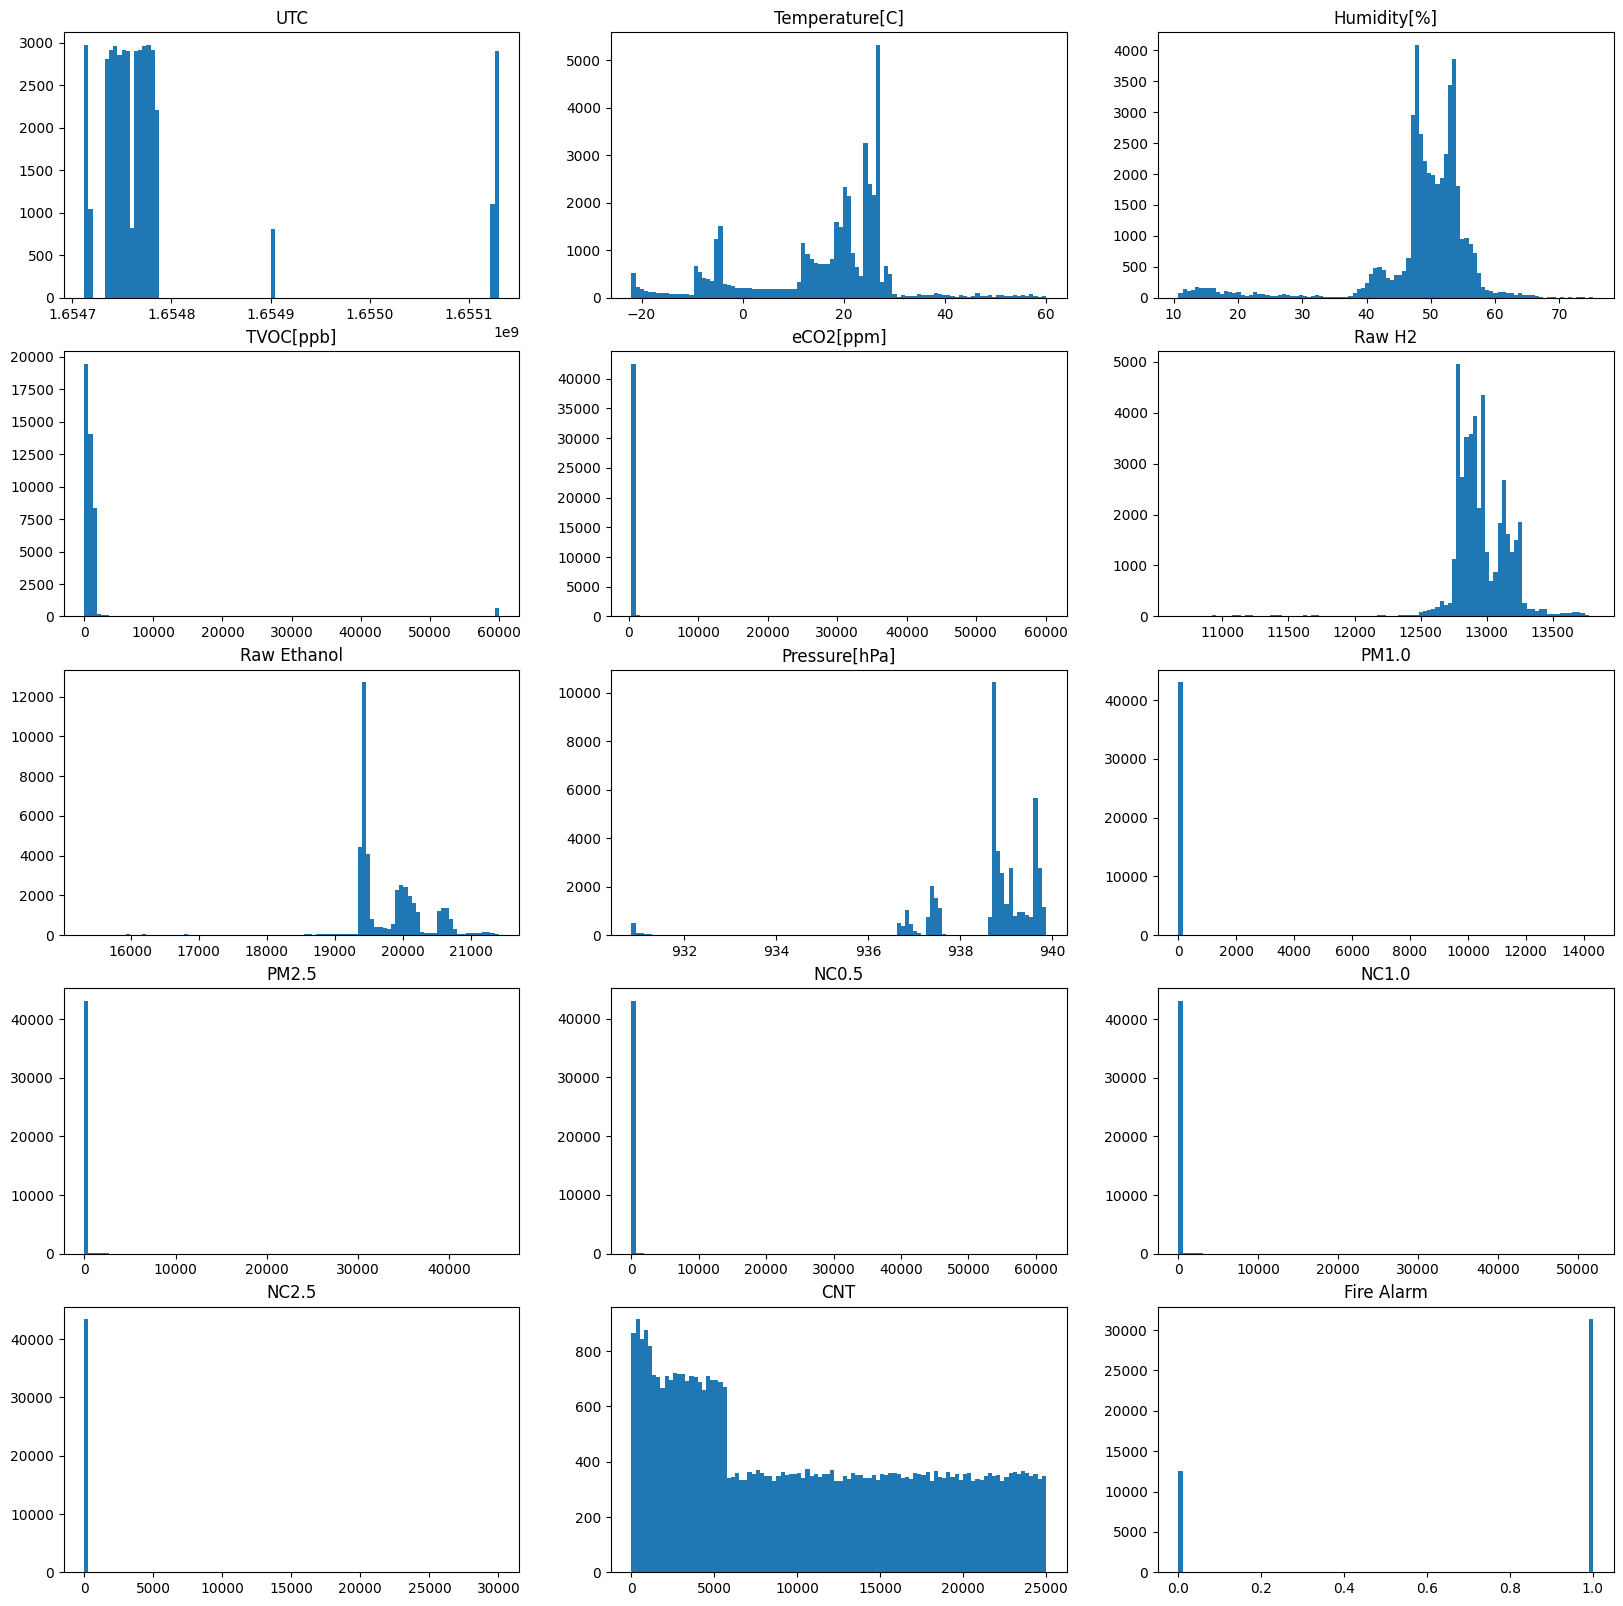

In [74]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
for j,i in enumerate(dataset.columns):
    ax[j//3, j%3].hist(dataset[i], bins=100)
    ax[j//3, j%3].set_title(i)
plt.show()

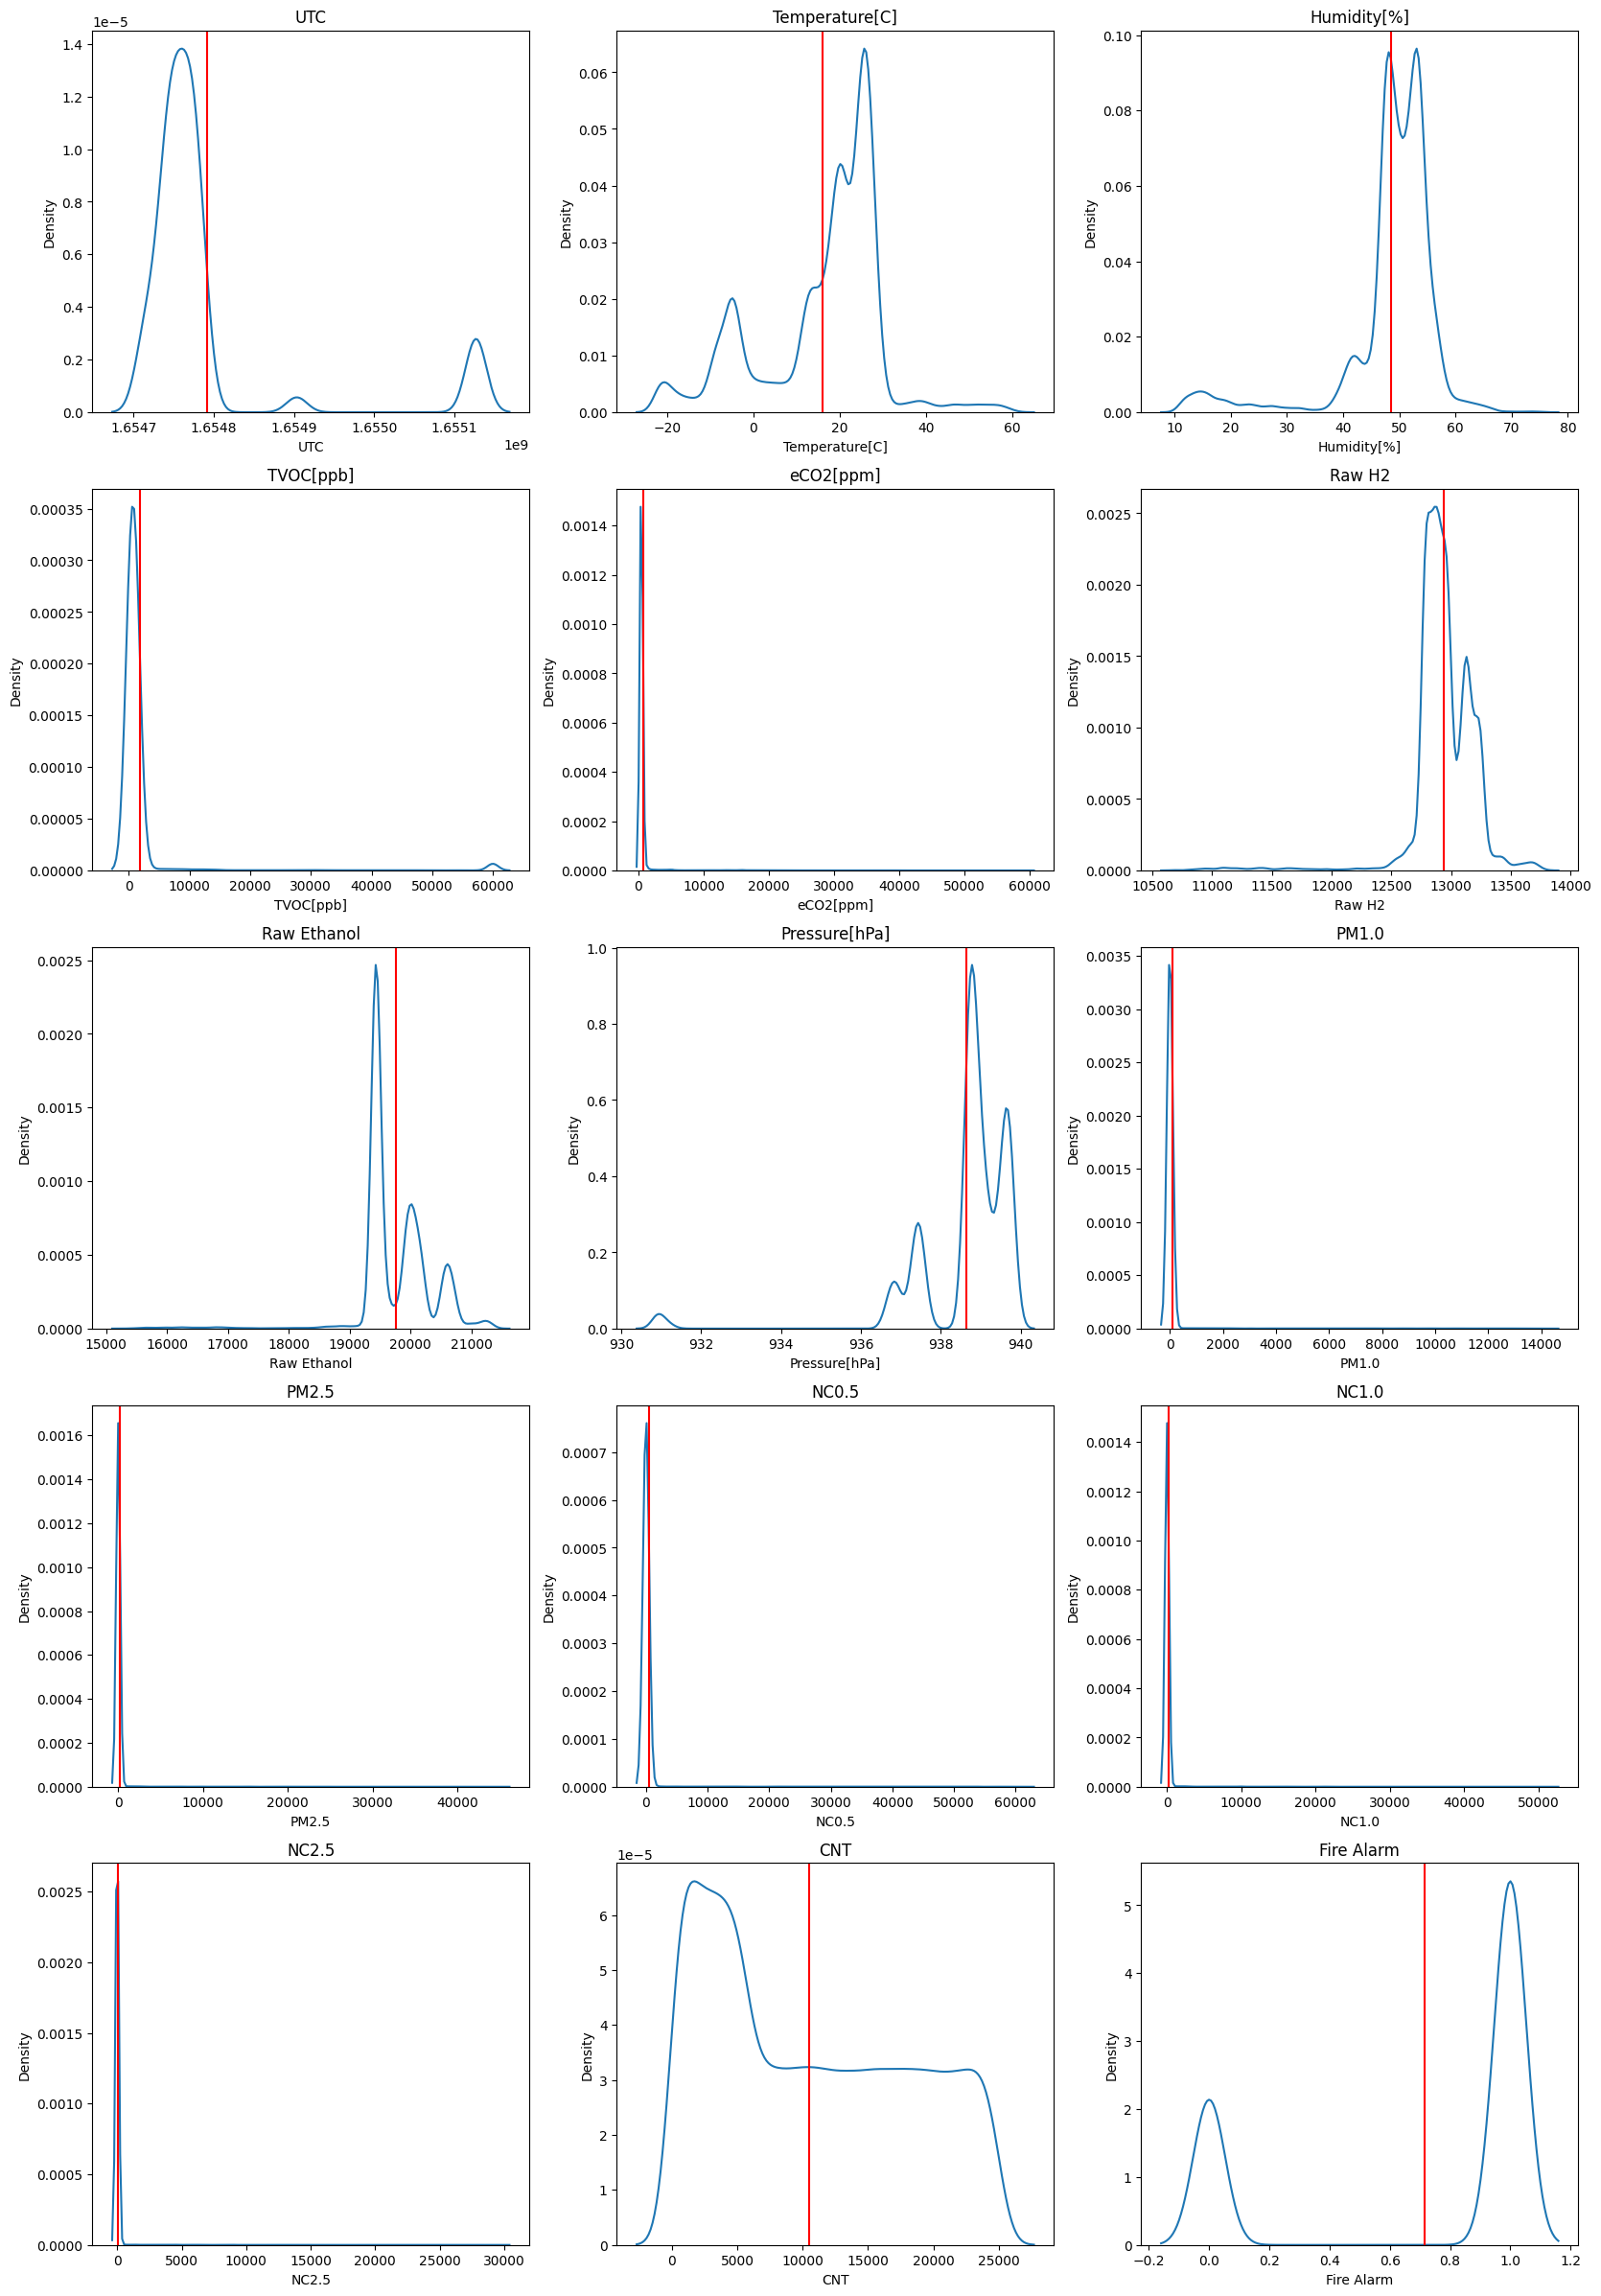

In [75]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20,30))
for j,i in enumerate(dataset.columns):
    sns.kdeplot(dataset[i], ax=ax[j//3,j%3])
    ax[j//3, j%3].axvline(dataset[i].mean(), 0, 1, color = 'r')
    ax[j//3, j%3].set_title(i)
plt.show()


### Multivariate Analysis

/tmp/ipykernel_318/1388542155.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataset, x=i, ax=ax[j//3,j%3], hue=target)


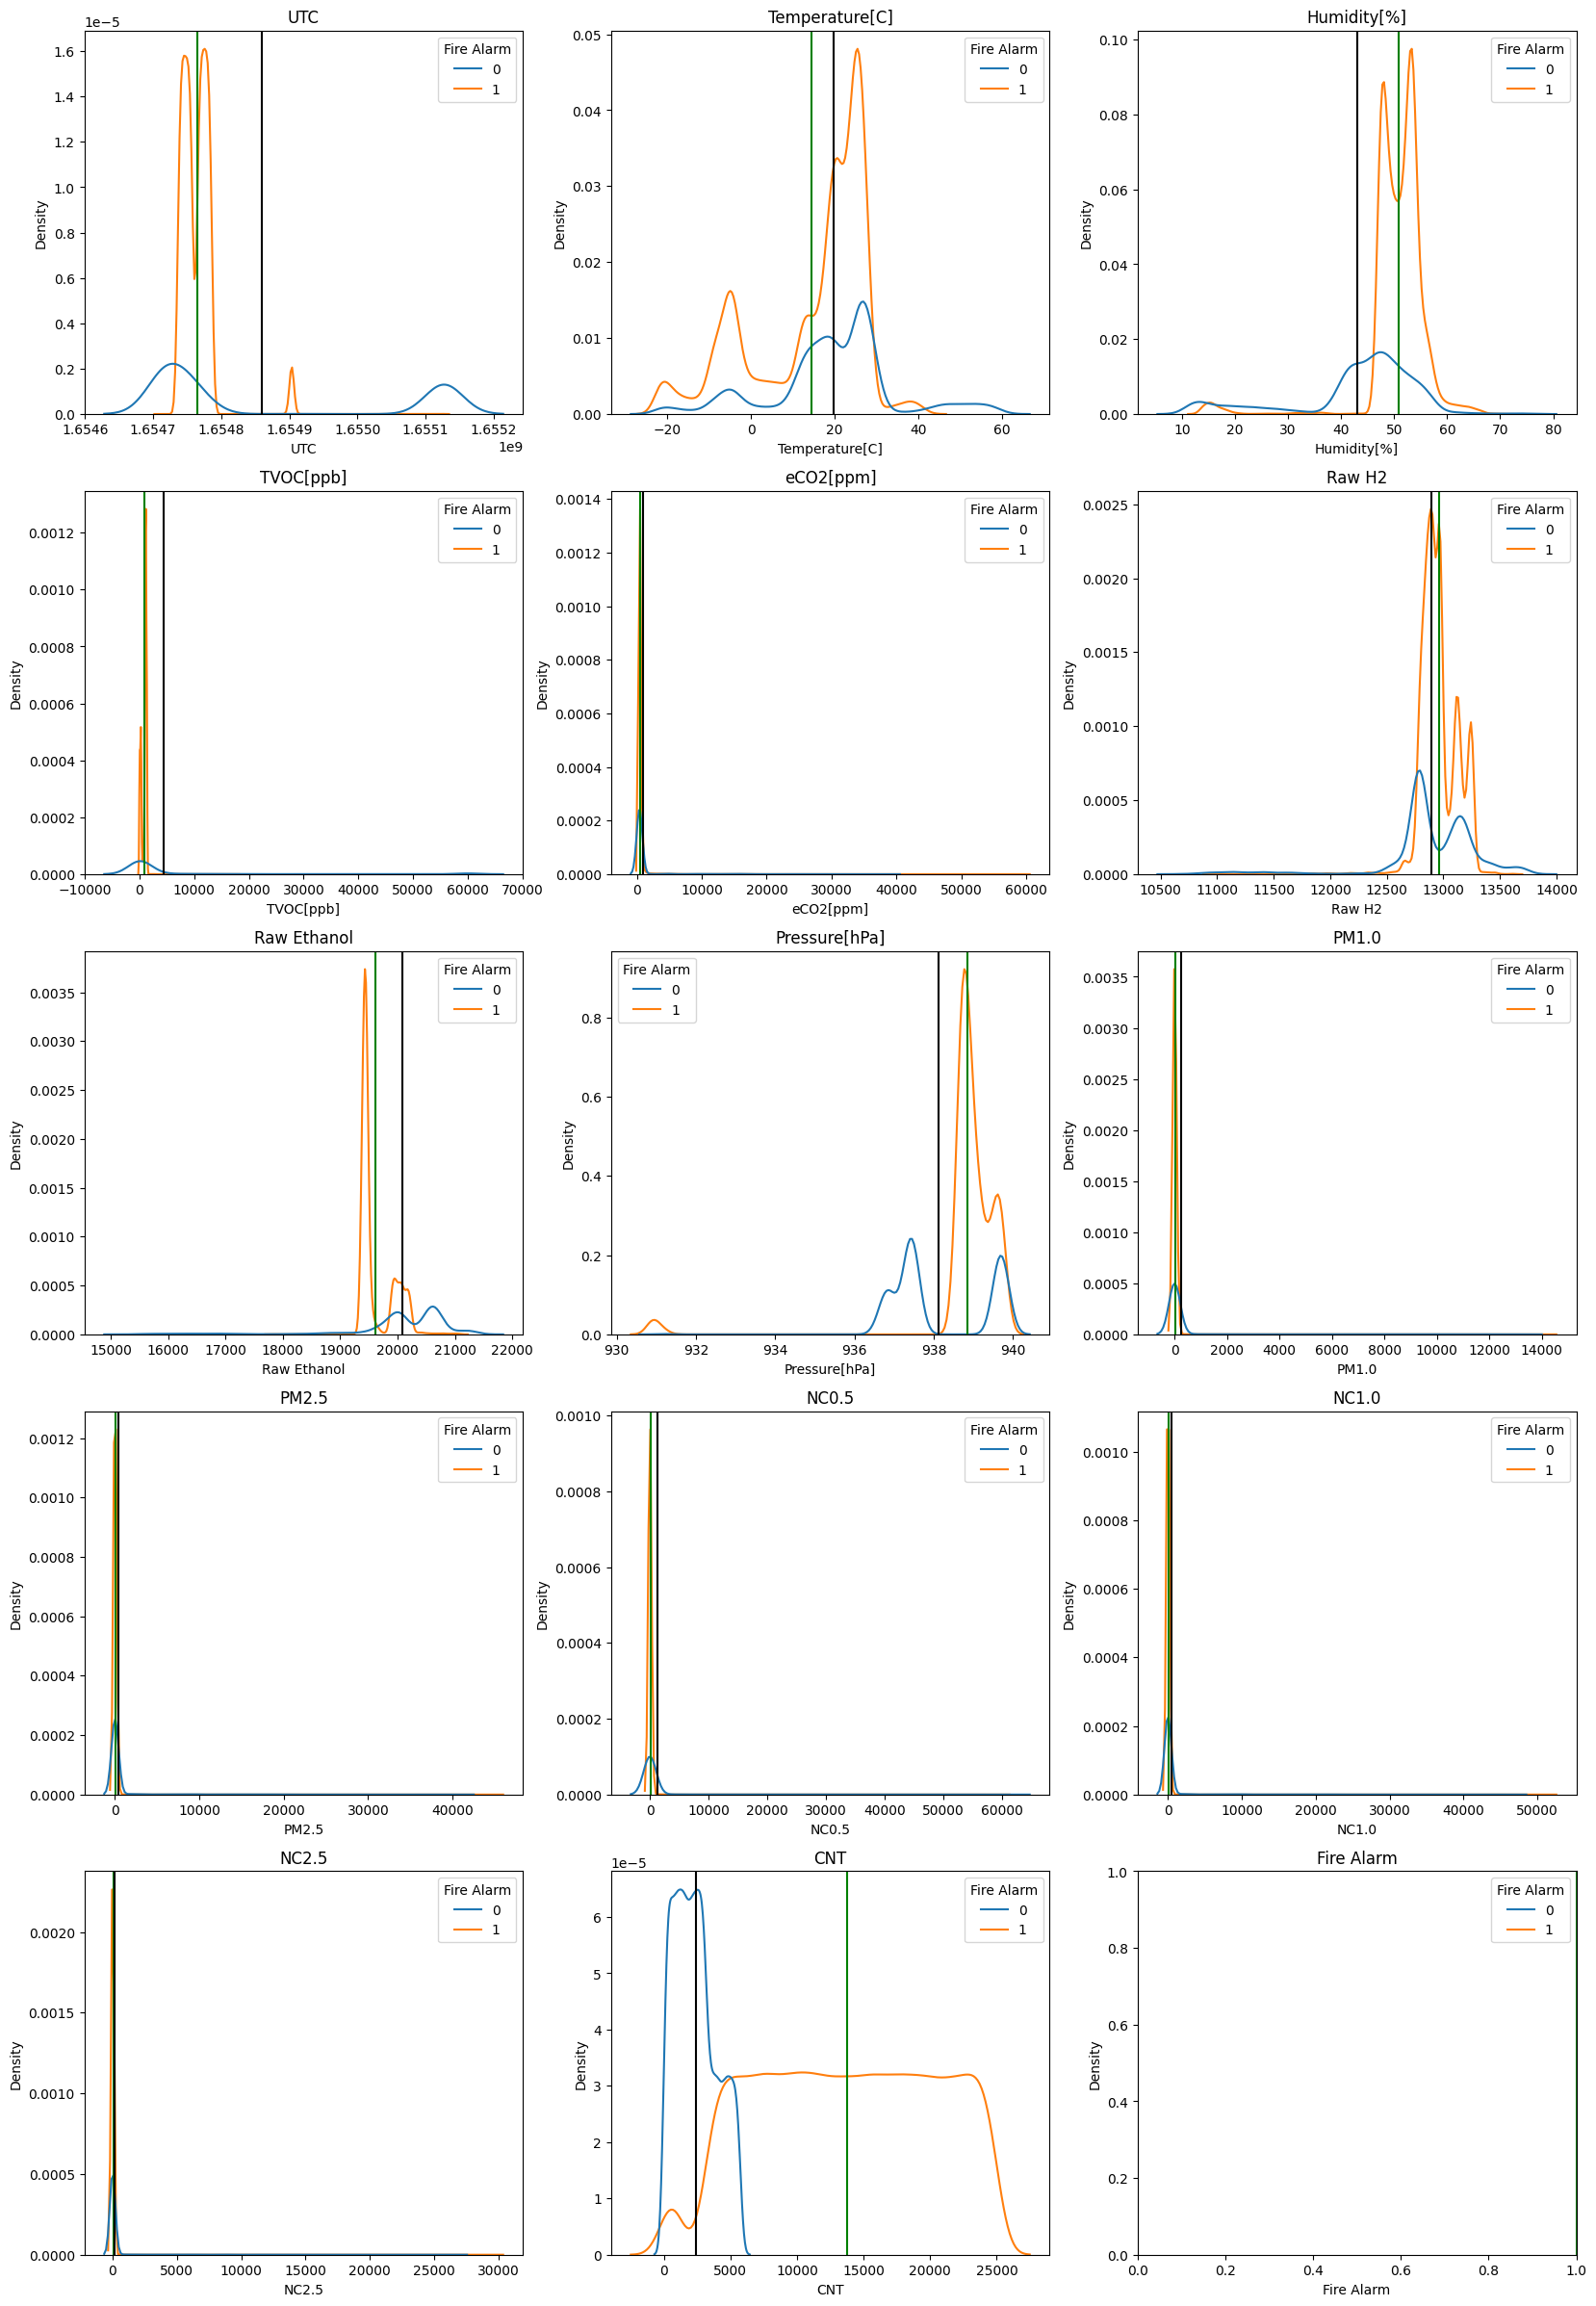

In [76]:
target = 'Fire Alarm'

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20,30))
for j,i in enumerate(dataset.columns):
    sns.kdeplot(data=dataset, x=i, ax=ax[j//3,j%3], hue=target)
    ax[j//3, j%3].axvline(dataset_fire[i].mean(), 0, 1, color = 'g')
    ax[j//3, j%3].axvline(dataset_no_fire[i].mean(), 0, 1, color = 'k')
    ax[j//3, j%3].set_title(i)
plt.show()



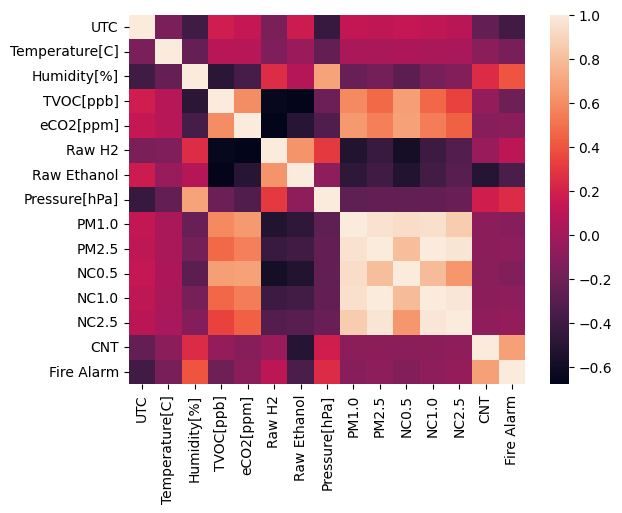

In [79]:
sns.heatmap(dataset.corr(numeric_only = True))
plt.show()

### T-Test

In [49]:
dataset.columns

Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]',
       'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5',
       'NC1.0', 'NC2.5', 'CNT', 'Fire Alarm'],
      dtype='object')

In [85]:
for i in dataset.columns:
    # perform t-test untuk 2 variabel
    t1 = scs.ttest_ind(
        dataset_fire[dataset_fire[i].isnull() != True][i],
        dataset_no_fire[dataset_no_fire[i].isnull() != True][i])

    # nilai t critical untuk alpha 0.05
    t2 = scs.t.ppf(0.05, df = (len(dataset) - 2))
    print('---- '+i+' ----')
    print(t1)
    print(t2)
    print('            ')

---- UTC ----
Ttest_indResult(statistic=-87.82974637647966, pvalue=0.0)
-1.6448883859912313
            
---- Temperature[C] ----
Ttest_indResult(statistic=-34.674930402354356, pvalue=6.258734713476929e-260)
-1.6448883859912313
            
---- Humidity[%] ----
Ttest_indResult(statistic=90.59918894767766, pvalue=0.0)
-1.6448883859912313
            
---- TVOC[ppb] ----
Ttest_indResult(statistic=-45.20655927172049, pvalue=0.0)
-1.6448883859912313
            
---- eCO2[ppm] ----
Ttest_indResult(statistic=-19.88256845310668, pvalue=1.403318457429268e-87)
-1.6448883859912313
            
---- Raw H2 ----
Ttest_indResult(statistic=22.362516063393223, pvalue=3.777952874801473e-110)
-1.6448883859912313
            
---- Raw Ethanol ----
Ttest_indResult(statistic=-77.23109660947631, pvalue=0.0)
-1.6448883859912313
            
---- Pressure[hPa] ----
Ttest_indResult(statistic=53.502441326467356, pvalue=0.0)
-1.6448883859912313
            
---- PM1.0 ----
Ttest_indResult(statistic=-22.643424

/tmp/ipykernel_318/1390784185.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t1 = scs.ttest_ind(


In [86]:
# dengan nilai t-value < t-critical dan nilai p-value < 0.05 maka h0 di reject
# mean antara kelas 0 dan kelas 1 untuk column.name statistically significant

### Check Outlier

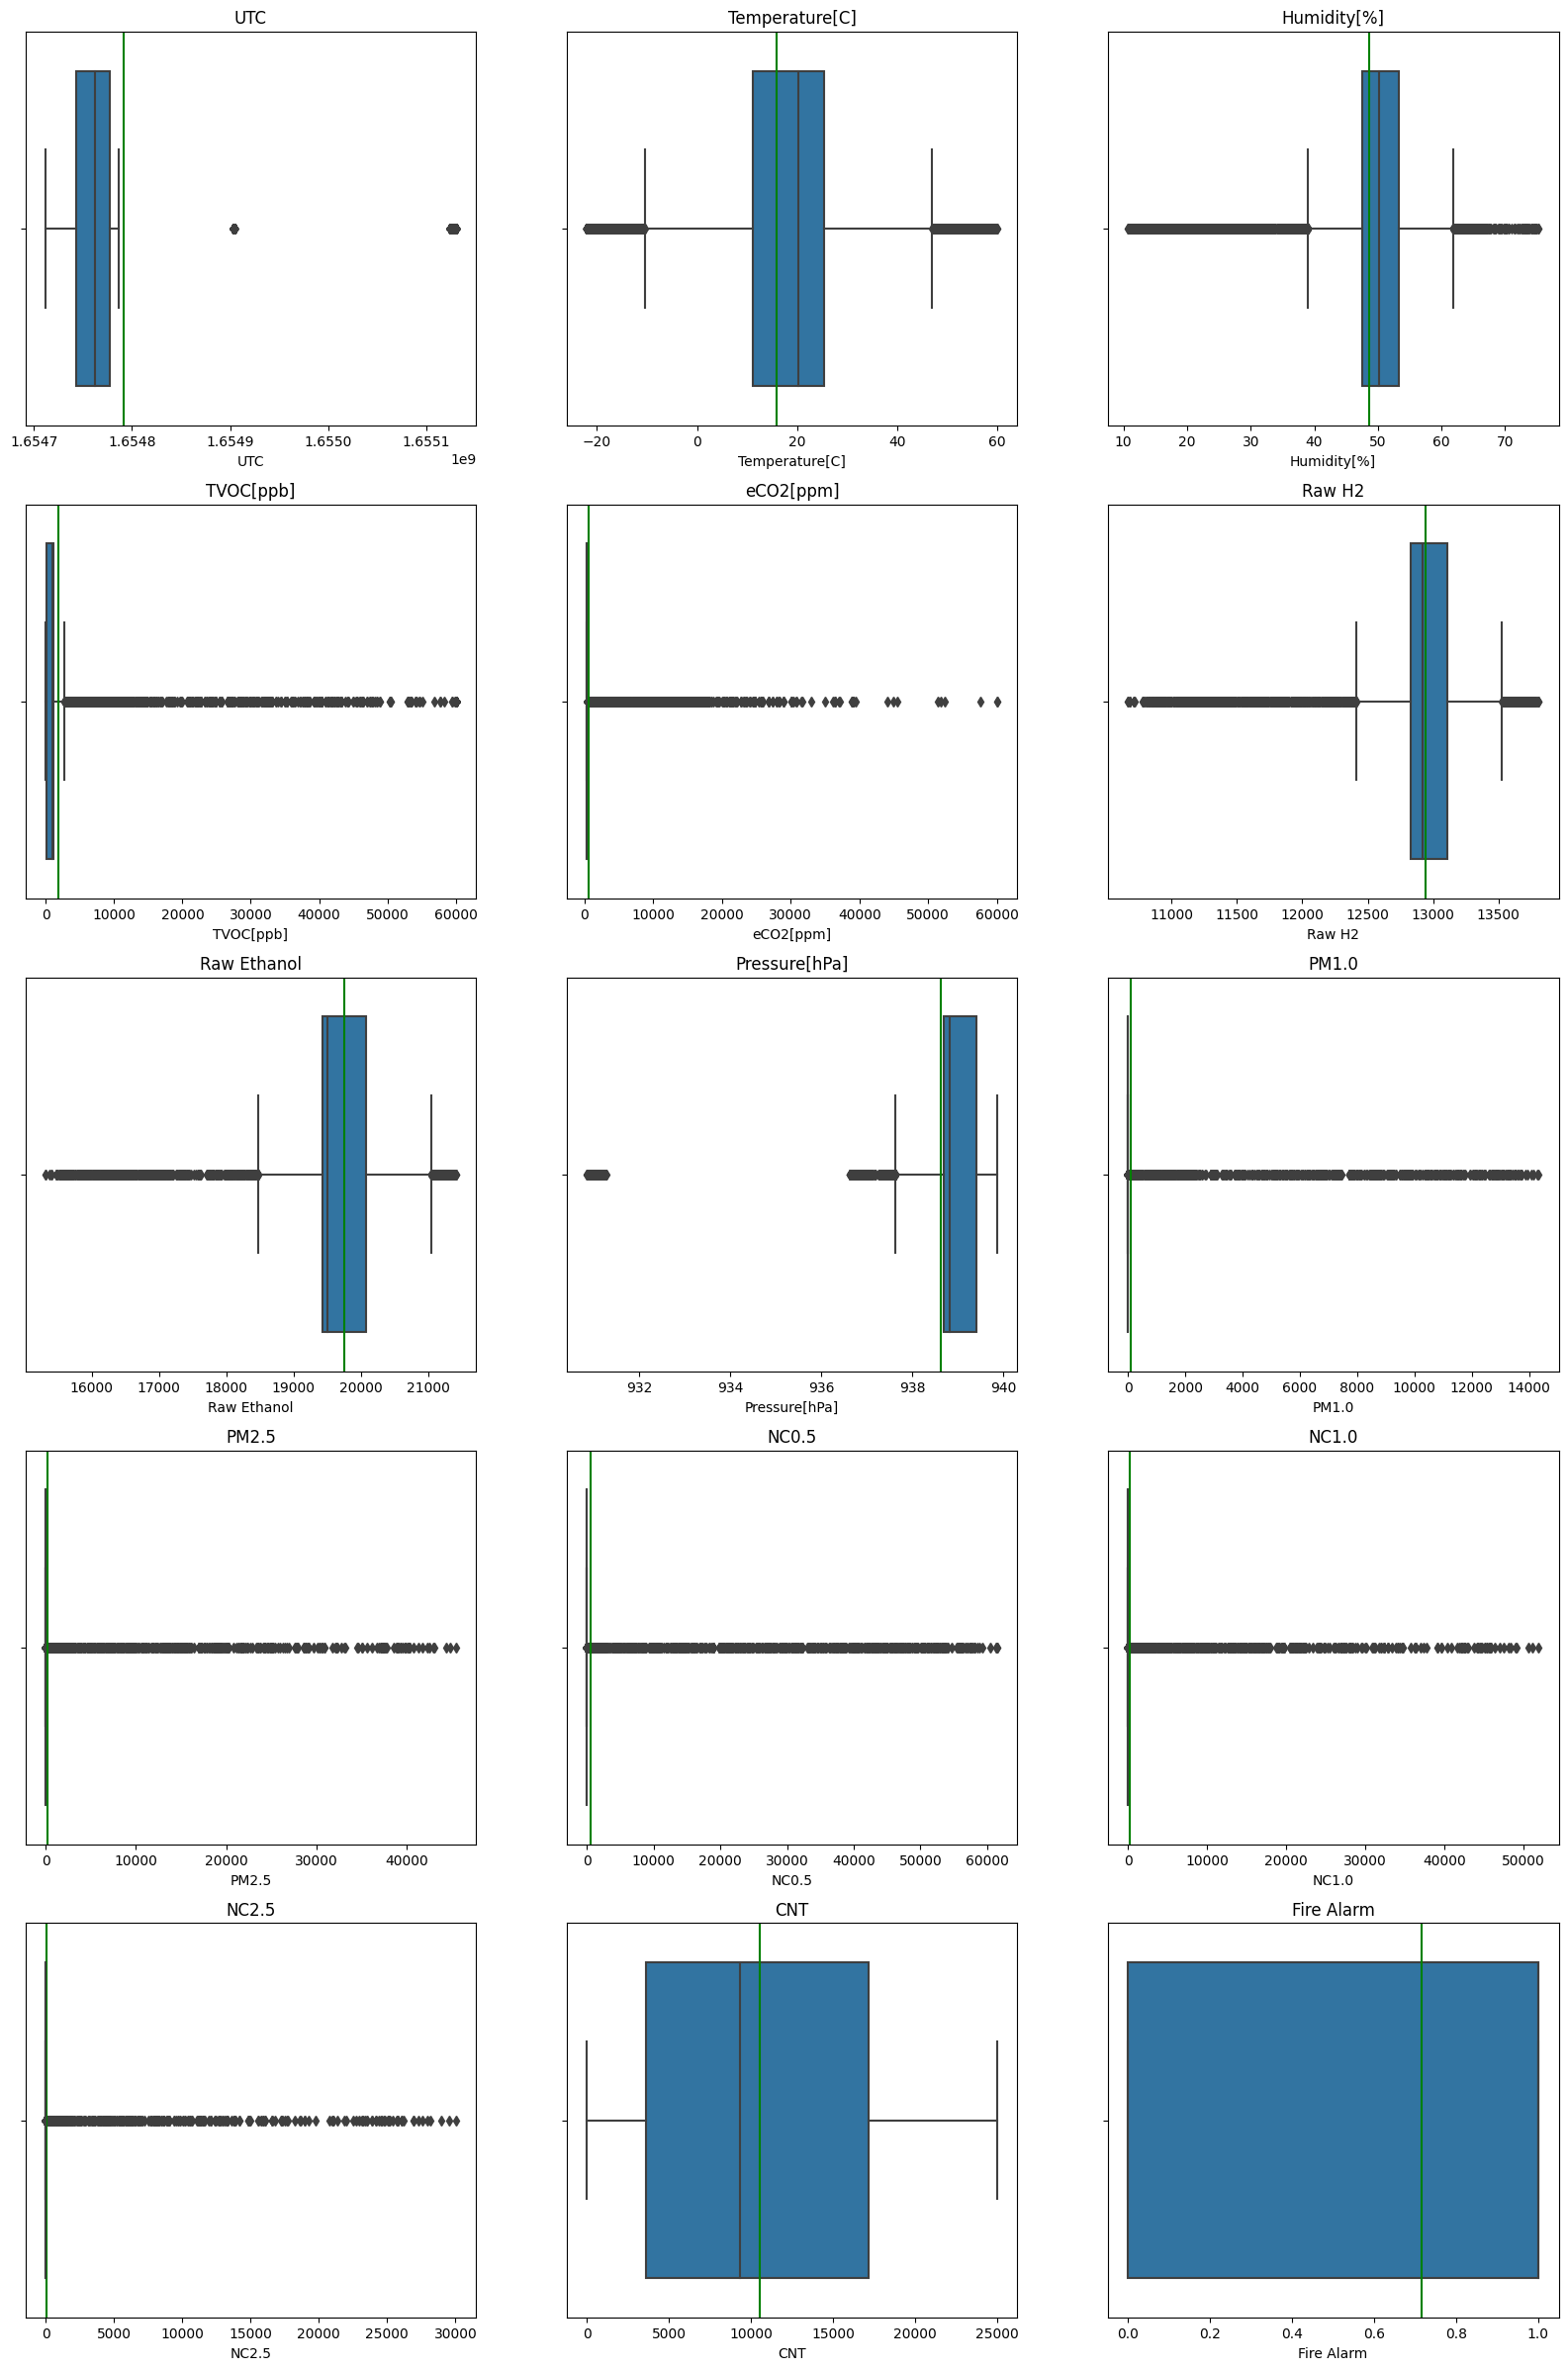

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20,30))
for j,i in enumerate(dataset.columns):
    sns.boxplot(data=dataset, x=i, ax=ax[j//3,j%3], hue=target)
    ax[j//3, j%3].axvline(dataset[i].mean(), 0, 1, color = 'g')
    ax[j//3, j%3].set_title(i)
plt.show()

### Check Imbalance Data

In [89]:
# TRAINSET
y_train.value_counts()

1    31330
0    12511
Name: Fire Alarm, dtype: int64

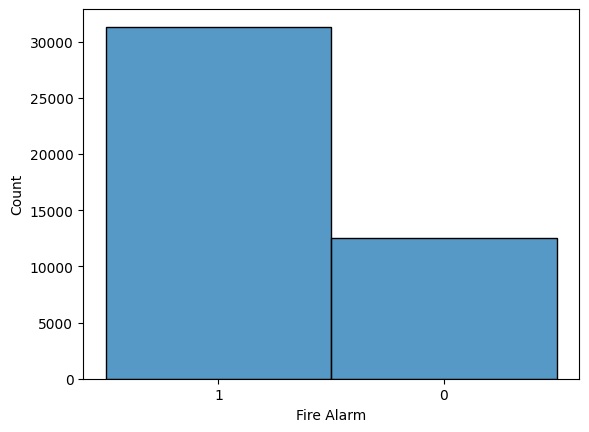

In [102]:
sns.histplot(data = y_train.astype(str))
plt.show()

In [92]:
# TESTSET
y_test.value_counts()

1    6714
0    2681
Name: Fire Alarm, dtype: int64

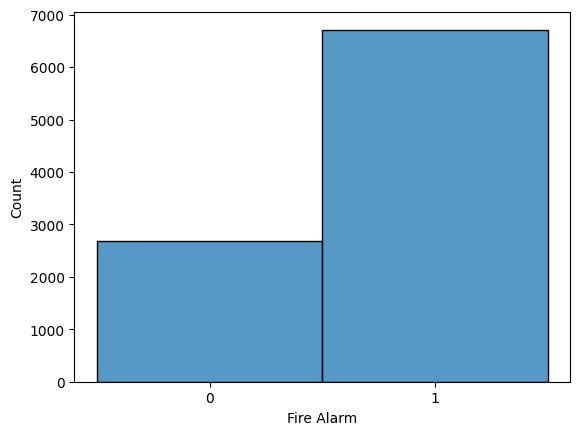

In [101]:
sns.histplot(data = y_test.astype(str))
plt.show()

In [94]:
# VALIDSET
y_valid.value_counts()

1    6713
0    2681
Name: Fire Alarm, dtype: int64

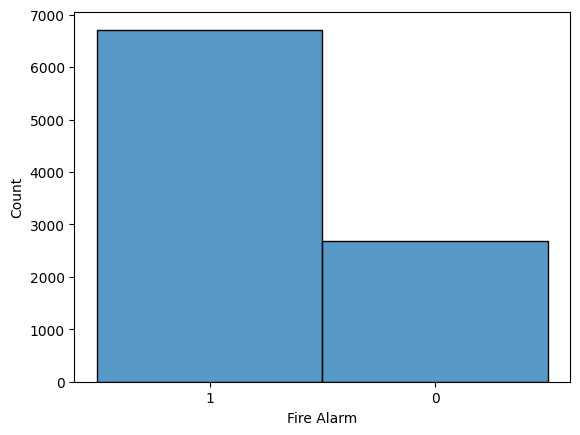

In [103]:
sns.histplot(data = y_valid.astype(str))
plt.show()

In [96]:
# Semua data target pada ketiga data set, imbalance

## Balancing Label

In [110]:
dataset['Fire Alarm'].value_counts()

1    31330
0    12511
Name: Fire Alarm, dtype: int64

### UnderSampling

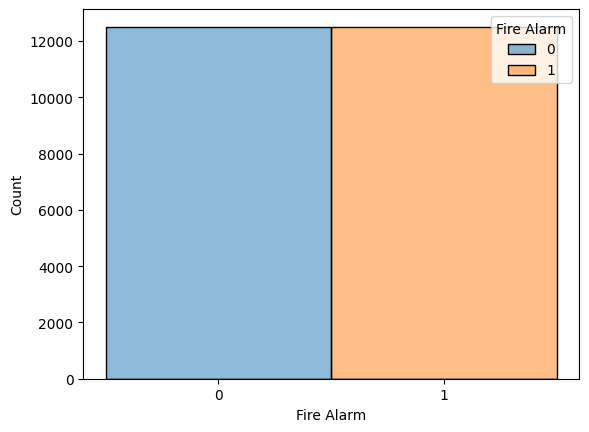

In [106]:
rus = RandomUnderSampler(random_state = 26)
x_rus, y_rus = rus.fit_resample(dataset.drop('Fire Alarm', axis = 1), dataset['Fire Alarm'])
dataset_rus = pd.concat([x_rus, y_rus], axis = 1)
sns.histplot(dataset_rus.astype(str), x = 'Fire Alarm', hue = 'Fire Alarm')
plt.show()

In [111]:
dataset_rus['Fire Alarm'].value_counts()

0    12511
1    12511
Name: Fire Alarm, dtype: int64

### OverSampling

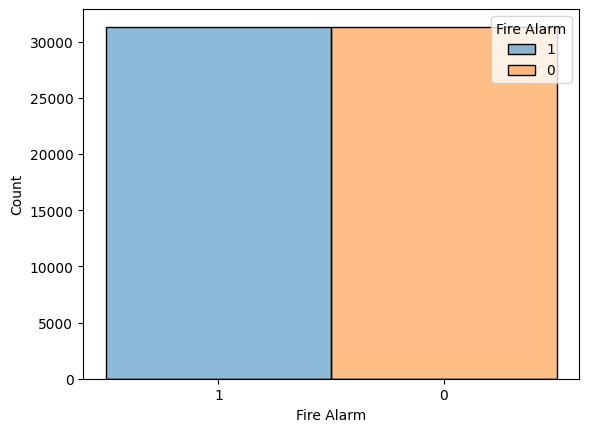

In [117]:
ros = RandomOverSampler(random_state = 11)
x_ros, y_ros = ros.fit_resample(dataset.drop('Fire Alarm', axis = 1), dataset['Fire Alarm'])
dataset_ros = pd.concat([x_ros, y_ros], axis = 1)
sns.histplot(dataset_ros.astype(str), x = 'Fire Alarm', hue = 'Fire Alarm')
plt.show()

In [118]:
dataset_ros['Fire Alarm'].value_counts()

1    31330
0    31330
Name: Fire Alarm, dtype: int64

### SMOTE

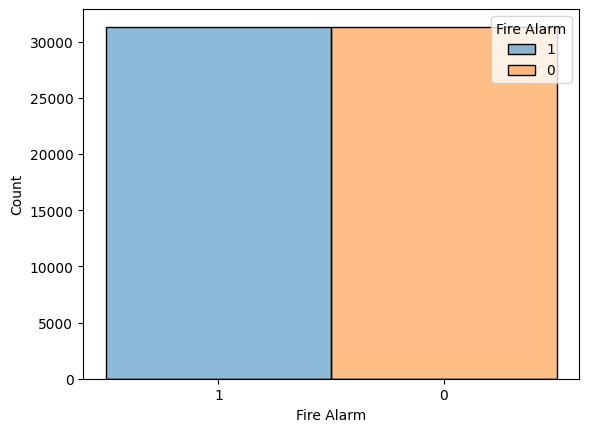

In [119]:
sm = SMOTE(random_state = 112)
x_sm, y_sm = sm.fit_resample(dataset.drop('Fire Alarm', axis = 1), dataset['Fire Alarm'])
dataset_sm = pd.concat([x_sm, y_sm], axis = 1)
sns.histplot(dataset_sm.astype(str), x = 'Fire Alarm', hue = 'Fire Alarm')
plt.show()

In [120]:
dataset_sm['Fire Alarm'].value_counts()

1    31330
0    31330
Name: Fire Alarm, dtype: int64

In [126]:
joblib.dump(x_rus, '../data/processed/x_rus.pkl')
joblib.dump(y_rus, '../data/processed/y_rus.pkl')

joblib.dump(x_ros, '../data/processed/x_ros.pkl')
joblib.dump(y_ros, '../data/processed/y_ros.pkl')

joblib.dump(x_sm, '../data/processed/x_sm.pkl')
joblib.dump(y_sm, '../data/processed/y_sm.pkl')

joblib.dump(x_valid, '../data/processed/x_valid.pkl')
joblib.dump(y_valid, '../data/processed/y_valid.pkl')

joblib.dump(x_test, '../data/processed/x_test.pkl')
joblib.dump(y_test, '../data/processed/y_test.pkl')

['../data/processed/y_test.pkl']

### Log Template

In [127]:
def time_stamp():
    return datetime.now()

In [128]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [129]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

## Training and Evaluation

In [130]:
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

NameError: name 'LogisticRegression' is not defined

In [ ]:
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }